In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import torch
import time
import os
import re
from pandas.plotting import scatter_matrix
from datetime import datetime as dt
from sklearn.model_selection import train_test_split

# torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

### Import Dataset

In [8]:
clean_tiles = pd.read_csv('../Landsat_Data/Clear_Tiles_Williams_Fork_Reservoir.csv', names=['Files'], dtype='string')
clean_tiles

,Files
0,LT05_CU_011009_19840528_20190206_C01_V01_INWM.tif
1,LT05_CU_011009_19840613_20190604_C01_V01_INWM.tif
2,LT05_CU_011009_19840629_20190604_C01_V01_INWM.tif
3,LT05_CU_011009_19860603_20190603_C01_V01_INWM.tif
4,LT05_CU_011009_19860619_20190603_C01_V01_INWM.tif
...,...
150,LC08_CU_011009_20210603_20210616_C01_V01_INWM.tif
151,LC08_CU_011009_20210705_20210715_C01_V01_INWM.tif
152,LC08_CU_011009_20210907_20210921_C01_V01_INWM.tif
153,LC08_CU_011009_20210923_20211002_C01_V01_INWM.tif


In [9]:
clean_tiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Files   155 non-null    string
dtypes: string(1)
memory usage: 1.3 KB


## Find If Tiles Are During Drought

In [10]:
df_drought_events = pd.read_csv("../Streamflow_Data/Streamflow_Drought_Data_CRB/Streamflow_Drought_Events/weibull_jd_Drought_Properties.csv")
df_drought_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107916 entries, 0 to 107915
Data columns (total 17 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   drought_id                                          107916 non-null  int64  
 1   severity                                            107916 non-null  float64
 2   mean_intensity                                      107916 non-null  float64
 3   max_intensity                                       107916 non-null  float64
 4   duration                                            107916 non-null  int64  
 5   start                                               107916 non-null  object 
 6   end                                                 107916 non-null  object 
 7   min_flow_cfs                                        107916 non-null  float64
 8   mean_flow_cfs                                       107916 non-n

In [11]:
gauge = '09037500'
df_site = df_drought_events.loc[df_drought_events['site'] == 'SW' + gauge]
df_site

,drought_id,severity,mean_intensity,max_intensity,duration,start,end,min_flow_cfs,mean_flow_cfs,max_flow_cfs,flow_deficit_cfs,threshold,site,dropped_zeros,previous_end,days_since_previous_drought,has_the_potential_to_be_impacted_by_missing_values
36559,1,33.292683,2.439024,2.439024,13,1980-04-07,1980-04-19,28.0000,29.043962,35.1429,80.704935,5,SW09037500,False,NaN,NaN,False
36560,3,124.756098,3.019744,2.439024,63,1981-01-01,1981-03-04,19.2857,23.736962,28.8571,273.199645,5,SW09037500,False,1980-04-19,257.0,False
36561,5,100.000000,2.500000,2.439024,40,1981-04-21,1981-05-30,10.1857,23.700360,100.2857,1316.015460,5,SW09037500,False,1981-03-04,48.0,False
36562,7,0.975610,4.878049,4.878049,8,1981-11-26,1981-12-03,27.5714,28.357138,30.4286,13.381510,5,SW09037500,False,1981-05-30,180.0,False
36563,8,23.658537,3.310105,2.439024,14,1981-12-10,1981-12-23,28.4286,29.142850,29.8571,18.522180,5,SW09037500,False,1981-12-03,7.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36822,134,170.000000,21.052632,14.634146,19,2018-03-05,2018-03-23,30.1857,31.512026,34.3429,23.548530,30,SW09037500,False,2017-10-03,153.0,False
36823,135,5314.146341,12.046803,2.439024,296,2018-06-11,2019-04-07,10.0614,41.650366,405.8571,5280.580140,30,SW09037500,False,2018-03-23,80.0,False
36824,136,19.512195,28.048780,26.829268,10,2019-05-27,2019-06-05,245.0000,260.885730,304.7143,321.614140,30,SW09037500,False,2019-04-07,50.0,False
36825,137,143.170732,22.464698,12.195122,19,2019-09-23,2019-10-11,23.1857,25.721784,37.1714,172.986030,30,SW09037500,False,2019-06-05,110.0,False


In [12]:
start = pd.to_datetime(df_site['start']).to_list()
start

[Timestamp('1980-04-07 00:00:00'),
 Timestamp('1981-01-01 00:00:00'),
 Timestamp('1981-04-21 00:00:00'),
 Timestamp('1981-11-26 00:00:00'),
 Timestamp('1981-12-10 00:00:00'),
 Timestamp('1982-04-02 00:00:00'),
 Timestamp('1982-05-20 00:00:00'),
 Timestamp('1983-04-12 00:00:00'),
 Timestamp('1987-11-18 00:00:00'),
 Timestamp('1988-08-05 00:00:00'),
 Timestamp('1988-10-24 00:00:00'),
 Timestamp('1989-09-05 00:00:00'),
 Timestamp('1990-02-21 00:00:00'),
 Timestamp('1994-12-20 00:00:00'),
 Timestamp('2000-07-29 00:00:00'),
 Timestamp('2002-03-25 00:00:00'),
 Timestamp('2002-04-27 00:00:00'),
 Timestamp('2002-05-27 00:00:00'),
 Timestamp('2002-06-08 00:00:00'),
 Timestamp('2002-10-10 00:00:00'),
 Timestamp('2002-11-01 00:00:00'),
 Timestamp('2010-10-02 00:00:00'),
 Timestamp('2010-10-17 00:00:00'),
 Timestamp('2012-05-30 00:00:00'),
 Timestamp('2012-10-06 00:00:00'),
 Timestamp('2013-04-20 00:00:00'),
 Timestamp('2017-09-11 00:00:00'),
 Timestamp('2018-08-15 00:00:00'),
 Timestamp('2018-11-

In [13]:
end = pd.to_datetime(df_site['end']).to_list()
end

[Timestamp('1980-04-19 00:00:00'),
 Timestamp('1981-03-04 00:00:00'),
 Timestamp('1981-05-30 00:00:00'),
 Timestamp('1981-12-03 00:00:00'),
 Timestamp('1981-12-23 00:00:00'),
 Timestamp('1982-04-11 00:00:00'),
 Timestamp('1982-05-26 00:00:00'),
 Timestamp('1983-04-19 00:00:00'),
 Timestamp('1987-12-10 00:00:00'),
 Timestamp('1988-08-29 00:00:00'),
 Timestamp('1988-11-19 00:00:00'),
 Timestamp('1989-09-11 00:00:00'),
 Timestamp('1990-04-07 00:00:00'),
 Timestamp('1995-02-20 00:00:00'),
 Timestamp('2000-08-05 00:00:00'),
 Timestamp('2002-04-01 00:00:00'),
 Timestamp('2002-05-19 00:00:00'),
 Timestamp('2002-06-02 00:00:00'),
 Timestamp('2002-08-07 00:00:00'),
 Timestamp('2002-10-16 00:00:00'),
 Timestamp('2002-11-08 00:00:00'),
 Timestamp('2010-10-06 00:00:00'),
 Timestamp('2010-10-24 00:00:00'),
 Timestamp('2012-07-24 00:00:00'),
 Timestamp('2012-10-30 00:00:00'),
 Timestamp('2013-04-26 00:00:00'),
 Timestamp('2017-09-28 00:00:00'),
 Timestamp('2018-10-09 00:00:00'),
 Timestamp('2018-11-

In [14]:
dates = []
for tile in clean_tiles['Files']:
    string_date = tile.split('_')[3]
    date = dt.strptime(string_date, '%Y%m%d')
    dates.append(date)
dates

[datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 6, 13, 0, 0),
 datetime.datetime(1984, 6, 29, 0, 0),
 datetime.datetime(1986, 6, 3, 0, 0),
 datetime.datetime(1986, 6, 19, 0, 0),
 datetime.datetime(1986, 7, 21, 0, 0),
 datetime.datetime(1986, 8, 6, 0, 0),
 datetime.datetime(1986, 10, 9, 0, 0),
 datetime.datetime(1987, 6, 22, 0, 0),
 datetime.datetime(1987, 7, 8, 0, 0),
 datetime.datetime(1987, 7, 24, 0, 0),
 datetime.datetime(1987, 9, 10, 0, 0),
 datetime.datetime(1987, 9, 26, 0, 0),
 datetime.datetime(1988, 5, 23, 0, 0),
 datetime.datetime(1988, 6, 8, 0, 0),
 datetime.datetime(1988, 6, 24, 0, 0),
 datetime.datetime(1988, 7, 10, 0, 0),
 datetime.datetime(1988, 8, 11, 0, 0),
 datetime.datetime(1988, 8, 27, 0, 0),
 datetime.datetime(1989, 7, 13, 0, 0),
 datetime.datetime(1989, 9, 15, 0, 0),
 datetime.datetime(1989, 10, 1, 0, 0),
 datetime.datetime(1990, 9, 2, 0, 0),
 datetime.datetime(1990, 10, 4, 0, 0),
 datetime.datetime(1991, 6, 17, 0, 0),
 datetime.datetime(1991, 7, 3,

In [15]:
in_drought = []
for i in range(0, len(dates)):
    for j in range(0, len(start)):
        if (dates[i] > start[j]) and (dates[i] < end[j]):
            in_drought.append(dates[i])
            break;
len(in_drought)

36

In [16]:
in_drought

[datetime.datetime(1987, 6, 22, 0, 0),
 datetime.datetime(1987, 7, 8, 0, 0),
 datetime.datetime(1987, 7, 24, 0, 0),
 datetime.datetime(1987, 9, 10, 0, 0),
 datetime.datetime(1988, 8, 11, 0, 0),
 datetime.datetime(1988, 8, 27, 0, 0),
 datetime.datetime(1989, 7, 13, 0, 0),
 datetime.datetime(1990, 9, 2, 0, 0),
 datetime.datetime(1992, 6, 19, 0, 0),
 datetime.datetime(1994, 6, 25, 0, 0),
 datetime.datetime(1994, 7, 11, 0, 0),
 datetime.datetime(1994, 8, 12, 0, 0),
 datetime.datetime(1996, 8, 17, 0, 0),
 datetime.datetime(1999, 5, 22, 0, 0),
 datetime.datetime(2000, 9, 13, 0, 0),
 datetime.datetime(2001, 6, 28, 0, 0),
 datetime.datetime(2001, 10, 2, 0, 0),
 datetime.datetime(2002, 7, 1, 0, 0),
 datetime.datetime(2002, 7, 17, 0, 0),
 datetime.datetime(2002, 10, 21, 0, 0),
 datetime.datetime(2003, 7, 20, 0, 0),
 datetime.datetime(2004, 6, 20, 0, 0),
 datetime.datetime(2004, 7, 6, 0, 0),
 datetime.datetime(2004, 9, 8, 0, 0),
 datetime.datetime(2006, 6, 26, 0, 0),
 datetime.datetime(2007, 9, 1

36 of the landsat observations are from within a drought. That means our target variable split is 36/155.

## Obtain Data for CNN

In [17]:
directory = '../Landsat_Data/DSWE_CRB/'

In [18]:
tiles = []
dates = []
for tile in clean_tiles['Files']:
    tif_file = rxr.open_rasterio(directory + tile)
    tif_file_sliced = tif_file.sel(x=slice(-864520, -854520), y=slice(1937400, 1927395))
    
    # Find date within tile filename
    tile_date = tile.split('_')[3]
    tile_date = [datetime(int(tile_date[:4]), int(tile_date[4:6]), int(tile_date[6:8])).date()]
        
    # Add date as a dimension to tile DataArray
    time_da = xr.DataArray(tile_date, [('time', tile_date[0:1])])
    tif_file = tif_file_sliced.expand_dims(time=time_da)
    
    dates.append(tile_date)
    tiles.append(tif_file)
len(tiles)

155

In [19]:
# tif_file = rxr.open_rasterio(directory + clean_tiles['Files'][0])
# tif_file_sliced = tif_file.sel(x=slice(-864520, -854520), y=slice(1937400, 1927395))
# print(tif_file_sliced.values.shape)
# plt.imshow(tif_file_sliced[0])

In [20]:
tiles[0].time.values[0]

datetime.date(1984, 5, 28)

In [21]:
tiles[0].values.shape

(1, 1, 334, 334)

(array([0, 1, 2, 3, 4], dtype=uint8),
 array([104999,   4566,     33,    250,   1708]))

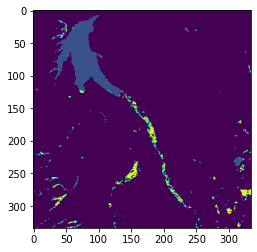

In [22]:
plt.imshow(tiles[0][0][0])
np.unique(tiles[0][0][0].values, return_counts=True)

## Preprocess Data for CNN

In [23]:
gauge_num = "09037500"
df_orig = pd.read_csv(
    "../Streamflow_Data/Streamflow_clean_" + gauge_num + ".csv", 
    index_col = "Date", 
    parse_dates=True
)
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14062 entries, 1981-10-01 to 2020-03-31
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tmmx_mean             14062 non-null  float64
 1   log_tmmx_var          14062 non-null  float64
 2   tmmn_mean             14062 non-null  float64
 3   log_tmmn_var          14062 non-null  float64
 4   pr_mean               14062 non-null  float64
 5   pr_var                14062 non-null  float64
 6   pr_sum                14062 non-null  float64
 7   SPEI_mean             14062 non-null  float64
 8   SPEI_stdev            14062 non-null  float64
 9   pet_mean              14062 non-null  float64
 10  pet_var               14062 non-null  float64
 11  pet_sum               14062 non-null  float64
 12  SoilM_0_10cm_mean     14062 non-null  float64
 13  SoilM_0_10cm_stdev    14062 non-null  float64
 14  SoilM_10_40cm_mean    14062 non-null  float64
 15  So

In [24]:
periods = -1
df_orig["weibull_jd_30d_avg_" + str(periods)[1:]] = df_orig["weibull_jd_30d_avg"].shift(periods=periods)
df_orig = df_orig.drop("weibull_jd_30d_avg", axis=1)
df_orig.tail(10)

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,pet_sum,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg_1
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,31.0,0.397940,32.7,0.397940,4.9,2.9,145.0,-0.312,-0.312,1.6,...,46.4,34.28,4.66,80.41,16.68,129.98,8.38,268.25,80.41,41.176471
2020-03-23,33.9,0.380211,31.6,0.380211,5.1,4.3,149.3,-0.208,-0.208,1.9,...,55.8,34.26,4.65,80.47,16.55,130.10,8.41,271.24,81.83,52.135375
2020-03-24,36.0,0.602060,36.5,0.602060,0.5,0.6,13.9,-0.104,-0.104,2.6,...,75.0,34.30,4.69,80.58,16.52,130.21,8.43,275.16,83.41,56.325544
2020-03-25,36.4,0.556303,38.5,0.556303,0.0,0.0,0.0,0.000,0.000,3.0,...,86.8,34.32,4.72,80.67,16.46,130.34,8.46,276.11,85.02,56.728445
2020-03-26,38.6,0.491362,35.3,0.491362,0.0,0.0,0.0,0.108,0.108,3.1,...,90.8,34.36,4.81,80.81,16.46,130.46,8.49,276.18,86.85,55.358582
2020-03-27,31.2,0.505150,30.0,0.505150,7.5,6.3,222.3,0.216,0.216,1.6,...,46.1,34.38,4.90,80.98,16.50,130.60,8.54,276.10,87.40,45.527800
2020-03-28,27.3,0.643453,27.5,0.643453,0.3,0.2,7.1,0.324,0.324,1.3,...,36.6,34.31,4.85,81.06,16.38,130.74,8.58,280.59,89.11,40.290089
2020-03-29,32.1,0.707570,28.6,0.707570,0.8,0.9,24.1,0.432,0.432,1.8,...,50.2,34.26,4.81,81.09,16.20,130.85,8.60,281.15,89.42,41.821112
2020-03-30,34.1,0.447158,33.6,0.447158,0.4,0.3,8.9,0.540,0.540,2.0,...,58.3,34.23,4.81,81.18,16.15,130.97,8.61,282.60,89.21,44.883159


In [25]:
df_orig = df_orig[df_orig["weibull_jd_30d_avg_" + str(periods)[1:]].notnull()]
df_orig.tail(10)

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,pet_sum,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg_1
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-21,33.8,0.591065,30.9,0.591065,2.7,0.7,79.0,-0.416,-0.416,1.8,...,53.3,34.32,4.67,80.33,16.76,129.86,8.36,265.15,79.78,55.761483
2020-03-22,31.0,0.397940,32.7,0.397940,4.9,2.9,145.0,-0.312,-0.312,1.6,...,46.4,34.28,4.66,80.41,16.68,129.98,8.38,268.25,80.41,41.176471
2020-03-23,33.9,0.380211,31.6,0.380211,5.1,4.3,149.3,-0.208,-0.208,1.9,...,55.8,34.26,4.65,80.47,16.55,130.10,8.41,271.24,81.83,52.135375
2020-03-24,36.0,0.602060,36.5,0.602060,0.5,0.6,13.9,-0.104,-0.104,2.6,...,75.0,34.30,4.69,80.58,16.52,130.21,8.43,275.16,83.41,56.325544
2020-03-25,36.4,0.556303,38.5,0.556303,0.0,0.0,0.0,0.000,0.000,3.0,...,86.8,34.32,4.72,80.67,16.46,130.34,8.46,276.11,85.02,56.728445
2020-03-26,38.6,0.491362,35.3,0.491362,0.0,0.0,0.0,0.108,0.108,3.1,...,90.8,34.36,4.81,80.81,16.46,130.46,8.49,276.18,86.85,55.358582
2020-03-27,31.2,0.505150,30.0,0.505150,7.5,6.3,222.3,0.216,0.216,1.6,...,46.1,34.38,4.90,80.98,16.50,130.60,8.54,276.10,87.40,45.527800
2020-03-28,27.3,0.643453,27.5,0.643453,0.3,0.2,7.1,0.324,0.324,1.3,...,36.6,34.31,4.85,81.06,16.38,130.74,8.58,280.59,89.11,40.290089
2020-03-29,32.1,0.707570,28.6,0.707570,0.8,0.9,24.1,0.432,0.432,1.8,...,50.2,34.26,4.81,81.09,16.20,130.85,8.60,281.15,89.42,41.821112


## CNN Drought Classifier

In [288]:
y = []
for tile in tiles:
    if datetime.combine(tile.time.values[0], datetime.min.time()) in in_drought:
        y.append(1)
    else:
        y.append(0)
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [289]:
y = np.array(y).astype('long')

In [290]:
X = np.array(tiles).astype('long')
X

array([[[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       ...,



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0

In [312]:
for image in range(0, len(X)):
    X[image] = np.where(X[image] != 0, 1, X[image])
X

array([[[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       ...,



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0

In [321]:
np.unique(X)

array([0, 1])

In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(124, 1, 1, 334, 334)
(31, 1, 1, 334, 334)
(124,)
(31,)


In [323]:
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([124, 1, 1, 334, 334])
torch.Size([31, 1, 1, 334, 334])
torch.Size([124])
torch.Size([31])


In [324]:
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[3], X_train.shape[4]))
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[3], X_test.shape[4]))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([124, 1, 334, 334])
torch.Size([31, 1, 334, 334])
torch.Size([124])
torch.Size([31])


In [325]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [326]:
batch_size = 1
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [347]:
class StandardBlock(nn.Module):
    def __init__(self, in_depth, out_depth, stride=1):
        super(StandardBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_depth, 
            out_channels=out_depth, 
            kernel_size=(3,3),
            stride=stride,
            padding=1
        )
        self.batch_norm = nn.BatchNorm2d(out_depth)
        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        out = self.act_fn(x)
        return out

In [348]:
class StandardNetClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(StandardNetClassifier, self).__init__()
        self.standard1 = StandardBlock(in_depth=1, out_depth=32, stride=1)
        self.standard2 = StandardBlock(in_depth=32, out_depth=64, stride=1)
        self.standard3 = StandardBlock(in_depth=64, out_depth=64, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.linear = nn.Linear(in_features=64, out_features=2)

    def forward(self, x):
        x = self.standard1(x)
        x = self.standard2(x)
        x = self.standard3(x)
        x = self.avg_pool(x)
        x = x.view([x.shape[0], 64])
        out = self.linear(x)
        return out

In [349]:
model = StandardNetClassifier()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(class_cnn.parameters(), lr=1e-4)

StandardNetClassifier(
  (standard1): StandardBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): ReLU()
  )
  (standard2): StandardBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): ReLU()
  )
  (standard3): StandardBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): ReLU()
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [350]:
for epoch in range(1): 
    for i, data in enumerate(train_loader, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        print(outputs)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()

#         if i % 10 == 0:   
        print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

tensor([[0.0781, 0.0855]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     1 loss: 0.689
tensor([[0.0554, 0.0834]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     2 loss: 0.707
tensor([[0.0578, 0.0750]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     3 loss: 0.685
tensor([[0.0670, 0.0735]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     4 loss: 0.696
tensor([[0.0602, 0.0759]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     5 loss: 0.685
tensor([[0.0556, 0.0674]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     6 loss: 0.687
tensor([[0.0599, 0.0780]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     7 loss: 0.684
tensor([[0.0607, 0.0734]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     8 loss: 0.700
tensor([[0.0634, 0.0750]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     9 loss: 0.699
tensor([[0.0507, 0.0703]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    10 loss: 0.703
tensor([[0.0533, 0.0761]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    11 loss: 0.705

Epoch: 1 Minibatch:    91 loss: 0.701
tensor([[0.0540, 0.0764]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    92 loss: 0.704
tensor([[0.0465, 0.0641]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    93 loss: 0.702
tensor([[0.0549, 0.0706]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    94 loss: 0.701
tensor([[0.0557, 0.0697]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    95 loss: 0.700
tensor([[0.0507, 0.0667]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    96 loss: 0.701
tensor([[0.0587, 0.0729]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    97 loss: 0.700
tensor([[0.0605, 0.0794]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    98 loss: 0.703
tensor([[0.0656, 0.0790]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    99 loss: 0.700
tensor([[0.0560, 0.0769]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:   100 loss: 0.704
tensor([[0.0609, 0.0735]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:   101 loss: 0.687
tensor([[0.0591, 0.0774]], grad_fn=<AddmmBackward0>)

In [355]:
with torch.no_grad():
    epoch_test_losses = []
    for i, data in enumerate(test_loader, 0):
        model.eval()
    
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.type(torch.LongTensor))

    if epoch % 10 == 0:   
        print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

Epoch: 1 Minibatch:    31 loss: 0.710


In [ ]:
torch.save(model.state_dict(), "cnn_outputs.pt")

## CNN for Images Placed On Streamflow Percentile Data

### Process Data into X and y

Downsample to monthly data

In [264]:
df_smooth = df_orig.resample('m').mean()
weibull_jd = df_smooth.iloc[:, -1]
weibull_jd

Date
1981-10-31    26.318526
1981-11-30     7.093742
1981-12-31     4.217596
1982-01-31    20.388498
1982-02-28    33.279613
                ...    
2019-11-30    55.304862
2019-12-31    64.882993
2020-01-31    31.617731
2020-02-29    65.364417
2020-03-31    67.249530
Freq: M, Name: weibull_jd_30d_avg_1, Length: 462, dtype: float64

In [259]:
weibull_jd.index.to_pydatetime()[0]

datetime.datetime(1981, 10, 31, 0, 0)

In [255]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

Find dates for each clear Landsat observation

In [256]:
image_dates = []
for tile in tiles:
    image_dates.append(datetime.combine(tile.time.values[0], datetime.min.time()))
image_dates

[datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 6, 13, 0, 0),
 datetime.datetime(1984, 6, 29, 0, 0),
 datetime.datetime(1986, 6, 3, 0, 0),
 datetime.datetime(1986, 6, 19, 0, 0),
 datetime.datetime(1986, 7, 21, 0, 0),
 datetime.datetime(1986, 8, 6, 0, 0),
 datetime.datetime(1986, 10, 9, 0, 0),
 datetime.datetime(1987, 6, 22, 0, 0),
 datetime.datetime(1987, 7, 8, 0, 0),
 datetime.datetime(1987, 7, 24, 0, 0),
 datetime.datetime(1987, 9, 10, 0, 0),
 datetime.datetime(1987, 9, 26, 0, 0),
 datetime.datetime(1988, 5, 23, 0, 0),
 datetime.datetime(1988, 6, 8, 0, 0),
 datetime.datetime(1988, 6, 24, 0, 0),
 datetime.datetime(1988, 7, 10, 0, 0),
 datetime.datetime(1988, 8, 11, 0, 0),
 datetime.datetime(1988, 8, 27, 0, 0),
 datetime.datetime(1989, 7, 13, 0, 0),
 datetime.datetime(1989, 9, 15, 0, 0),
 datetime.datetime(1989, 10, 1, 0, 0),
 datetime.datetime(1990, 9, 2, 0, 0),
 datetime.datetime(1990, 10, 4, 0, 0),
 datetime.datetime(1991, 6, 17, 0, 0),
 datetime.datetime(1991, 7, 3,

In [263]:
len(image_dates)

155

Find the nearest Landsat observation for each streamflow percentile value

In [260]:
nearest_image_date = []
for i in range(0, len(weibull_jd)):
    nearest_image_date.append(nearest(image_dates, weibull_jd.index.to_pydatetime()[i]))
nearest_image_date

[datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 

In [261]:
len(nearest_image_date)

462

In [265]:
df_smooth['image_date'] = nearest_image_date
df_smooth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 1981-10-31 to 2020-03-31
Freq: M
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tmmx_mean             462 non-null    float64       
 1   log_tmmx_var          462 non-null    float64       
 2   tmmn_mean             462 non-null    float64       
 3   log_tmmn_var          462 non-null    float64       
 4   pr_mean               462 non-null    float64       
 5   pr_var                462 non-null    float64       
 6   pr_sum                462 non-null    float64       
 7   SPEI_mean             462 non-null    float64       
 8   SPEI_stdev            462 non-null    float64       
 9   pet_mean              462 non-null    float64       
 10  pet_var               462 non-null    float64       
 11  pet_sum               462 non-null    float64       
 12  SoilM_0_10cm_mean     462 non-null    float64      

In [266]:
df = df_smooth.iloc[:, -2:]

In [267]:
df

,weibull_jd_30d_avg_1,image_date
Date,,
1981-10-31,26.318526,1984-05-28
1981-11-30,7.093742,1984-05-28
1981-12-31,4.217596,1984-05-28
1982-01-31,20.388498,1984-05-28
1982-02-28,33.279613,1984-05-28
...,...,...
2019-11-30,55.304862,2019-09-02
2019-12-31,64.882993,2019-09-02
2020-01-31,31.617731,2019-09-02


Create array of Landsat observation values, each value corresponds to one streamflow percentile value

In [268]:
X = []
for date in df['image_date']:
    found = False
    index = 0
    while found == False:
        if date == datetime.combine(tiles[index].time.values[0], datetime.min.time()):
            X.append(tiles[index].values)
            found = True
        else:
            index += 1
X = np.array(X)

In [269]:
len(X)

462

In [270]:
y = df.iloc[:, 0].to_numpy()
print(y)
y = np.round(y, 0)
y = y.astype(int)
print(y)

[26.31852564  7.09374161  4.21759589 20.38849814 33.27961322 14.1561176
 17.29250604 10.71456422 52.11925866 83.77739076 88.83314705 85.07117916
 84.73915417 64.21702928 32.35575837 35.6159649  36.49994244 30.75823347
 13.37899543 35.58004731 80.80848778 96.82098204 95.5057056  90.88638195
 81.96563645 81.89363417 43.96308068 40.77654948 52.28264192 26.40950326
 36.75799087 70.7857867  89.4547408  90.60591095 97.42143433 98.22992211
 95.9865873  98.38302444 98.09198963 96.65081891 93.05571544 75.39445296
 71.28391082 66.46564945 54.29760945 48.04658054 63.32042318 61.9070642
 78.56567284 63.37362342 67.08794417 67.3957062  53.76424542 66.92053755
 58.12785388 58.74034987 71.97690035 72.06207273 36.56000624 87.13134569
 78.6540511  79.84152565 52.16297085 16.60629936 31.15574997 34.66247303
 41.80499597 38.07023472 21.0018802  12.18060357 18.8479634  31.62503358
 23.05372878  8.42331453 16.27293077  8.61522747 10.36983523 35.52026202
 52.39860328 42.14863144 61.73784582 22.99914221  6.5

In [271]:
len(y)

462

### Standard CNN Construction

In [143]:
class MobileNetBlock(nn.Module):
    def __init__(self, in_depth, out_depth, stride=1):
        super(MobileNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_depth, 
            out_channels=in_depth, 
            kernel_size=(3,3), 
            groups=in_depth,
            stride=stride,
            padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(in_depth)
        self.act_fn1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_depth, out_depth, kernel_size=(1,1))
        self.batch_norm2 = nn.BatchNorm2d(out_depth)
        self.act_fn2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.act_fn1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        out = self.act_fn2(x)
        return out

In [285]:
class StandardBlock(nn.Module):
    def __init__(self, in_depth, out_depth, stride=1):
        super(StandardBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_depth, 
            out_channels=out_depth, 
            kernel_size=(3,3),
            stride=stride,
            padding=1
        )
        self.batch_norm = nn.BatchNorm2d(out_depth)
        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        out = self.act_fn(x)
        return out

In [182]:
class MobileNetV1(nn.Module):
    def __init__(self, num_classes=100):
        super(MobileNetV1, self).__init__()
        self.standard = StandardBlock(in_depth=1, out_depth=3, stride=1)
        self.mobile1 = MobileNetBlock(in_depth=3, out_depth=64, stride=1)
        self.mobile2 = MobileNetBlock(in_depth=64, out_depth=128, stride=2)
        self.mobile3 = MobileNetBlock(in_depth=128, out_depth=128, stride=1)
        self.mobile4 = MobileNetBlock(in_depth=128, out_depth=256, stride=2)
        self.mobile5 = MobileNetBlock(in_depth=256, out_depth=256, stride=1)
        self.mobile6 = MobileNetBlock(in_depth=256, out_depth=512, stride=2)
        self.mobile7 = MobileNetBlock(in_depth=512, out_depth=512, stride=1)
        self.mobile8 = MobileNetBlock(in_depth=512, out_depth=1024, stride=2)
        self.mobile9 = MobileNetBlock(in_depth=1024, out_depth=1024, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.linear = nn.Linear(in_features=1024, out_features=10)
    
    def forward(self, x):
        x = self.standard(x)
        x = self.mobile1(x)
        x = self.mobile2(x)
        x = self.mobile3(x)
        x = self.mobile4(x)
        x = self.mobile5(x)
        x = self.mobile6(x)
        x = self.mobile7(x)
        x = self.mobile8(x)
        x = self.mobile9(x)
        x = self.avg_pool(x)
        x = x.view([x.shape[0], 1024])
        out = self.linear(x)
        return out

In [310]:
class StandardNet(nn.Module):
    def __init__(self, num_classes=1):
        super(StandardNet, self).__init__()
        self.standard1 = StandardBlock(in_depth=1, out_depth=32, stride=1)
        self.standard2 = StandardBlock(in_depth=32, out_depth=64, stride=1)
        self.standard3 = StandardBlock(in_depth=64, out_depth=64, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = self.standard1(x)
        x = self.standard2(x)
        x = self.standard3(x)
        x = self.avg_pool(x)
        x = x.view([x.shape[0], 64])
        out = self.linear(x)
        return out

In [274]:
X_train = X[:int(len(X) * 0.8)]
X_test = X[int(len(X) * 0.8):]

y = y.reshape(-1, 1)
y_train = y[:int(len(y) * 0.8)]
y_test = y[int(len(y) * 0.8):]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(369, 1, 1, 334, 334)
(93, 1, 1, 334, 334)
(369, 1)
(93, 1)


In [275]:
X_train = Variable(torch.Tensor(X_train))
X_test = Variable(torch.Tensor(X_test))
y_train = Variable(torch.Tensor(y_train))
y_test = Variable(torch.Tensor(y_test))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([369, 1, 1, 334, 334])
torch.Size([93, 1, 1, 334, 334])
torch.Size([369, 1])
torch.Size([93, 1])


In [276]:
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[3], X_train.shape[4]))
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[3], X_test.shape[4]))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([369, 1, 334, 334])
torch.Size([93, 1, 334, 334])
torch.Size([369, 1])
torch.Size([93, 1])


In [277]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [287]:
batch_size = 1
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [311]:
stan_cnn = StandardNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(stan_cnn.parameters(), lr=1e-4)

In [280]:
len(list(enumerate(train_loader, 0)))

369

In [299]:
epochs = 1

In [312]:
for epoch in range(1): 
    for i, data in enumerate(train_loader, 0):
        stan_cnn.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = stan_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:   
            print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

Epoch: 1 Minibatch:     1 loss: 954.703
Epoch: 1 Minibatch:    11 loss: 1912.024
Epoch: 1 Minibatch:    21 loss: 7682.433
Epoch: 1 Minibatch:    31 loss: 1414.627
Epoch: 1 Minibatch:    41 loss: 4979.771
Epoch: 1 Minibatch:    51 loss: 5121.677
Epoch: 1 Minibatch:    61 loss: 1892.483
Epoch: 1 Minibatch:    71 loss: 1188.620
Epoch: 1 Minibatch:    81 loss: 1886.096
Epoch: 1 Minibatch:    91 loss: 2856.867
Epoch: 1 Minibatch:   101 loss: 1717.134
Epoch: 1 Minibatch:   111 loss: 2846.348
Epoch: 1 Minibatch:   121 loss: 337.830
Epoch: 1 Minibatch:   131 loss: 152.328
Epoch: 1 Minibatch:   141 loss: 1113.195
Epoch: 1 Minibatch:   151 loss: 4520.322
Epoch: 1 Minibatch:   161 loss: 4122.286
Epoch: 1 Minibatch:   171 loss: 104.066
Epoch: 1 Minibatch:   181 loss: 1696.424
Epoch: 1 Minibatch:   191 loss: 971.787
Epoch: 1 Minibatch:   201 loss: 4915.919
Epoch: 1 Minibatch:   211 loss: 3854.952
Epoch: 1 Minibatch:   221 loss: 627.923
Epoch: 1 Minibatch:   231 loss: 3029.036
Epoch: 1 Minibatch:   

In [314]:
with torch.no_grad():
    epoch_test_losses = []
    for i, data in enumerate(test_loader, 0):
        stan_cnn.eval()
    
        inputs, labels = data
        optimizer.zero_grad()
        outputs = stan_cnn(inputs)

        loss = criterion(outputs, labels)

        if i % 10 == 0:   
            print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

Epoch: 1 Minibatch:     1 loss: 73.974
Epoch: 1 Minibatch:    11 loss: 4309.938
Epoch: 1 Minibatch:    21 loss: 5558.429
Epoch: 1 Minibatch:    31 loss: 7356.068
Epoch: 1 Minibatch:    41 loss: 1340.929
Epoch: 1 Minibatch:    51 loss: 609.160
Epoch: 1 Minibatch:    61 loss: 2463.100
Epoch: 1 Minibatch:    71 loss: 3559.078
Epoch: 1 Minibatch:    81 loss: 114.267
Epoch: 1 Minibatch:    91 loss: 943.276


## CNN for Streamflow Percentile Data Placed on Images

Decided not to pursue this route

### Process Data into X and y

Find dates for each clear Landsat observation

In [215]:
image_dates = []
for tile in tiles:
    image_dates.append(datetime.combine(tile.time.values[0], datetime.min.time()))
image_dates

[datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 6, 13, 0, 0),
 datetime.datetime(1984, 6, 29, 0, 0),
 datetime.datetime(1986, 6, 3, 0, 0),
 datetime.datetime(1986, 6, 19, 0, 0),
 datetime.datetime(1986, 7, 21, 0, 0),
 datetime.datetime(1986, 8, 6, 0, 0),
 datetime.datetime(1986, 10, 9, 0, 0),
 datetime.datetime(1987, 6, 22, 0, 0),
 datetime.datetime(1987, 7, 8, 0, 0),
 datetime.datetime(1987, 7, 24, 0, 0),
 datetime.datetime(1987, 9, 10, 0, 0),
 datetime.datetime(1987, 9, 26, 0, 0),
 datetime.datetime(1988, 5, 23, 0, 0),
 datetime.datetime(1988, 6, 8, 0, 0),
 datetime.datetime(1988, 6, 24, 0, 0),
 datetime.datetime(1988, 7, 10, 0, 0),
 datetime.datetime(1988, 8, 11, 0, 0),
 datetime.datetime(1988, 8, 27, 0, 0),
 datetime.datetime(1989, 7, 13, 0, 0),
 datetime.datetime(1989, 9, 15, 0, 0),
 datetime.datetime(1989, 10, 1, 0, 0),
 datetime.datetime(1990, 9, 2, 0, 0),
 datetime.datetime(1990, 10, 4, 0, 0),
 datetime.datetime(1991, 6, 17, 0, 0),
 datetime.datetime(1991, 7, 3,

In [219]:
X = []
for date in image_dates:
    found = False
    index = 0
    while found == False:
        if date == datetime.combine(tiles[index].time.values[0], datetime.min.time()):
            X.append(tiles[index].values)
            found = True
        else:
            index += 1
X = np.array(X)

In [220]:
len(X)

155

In [242]:
weibull_jd = df_orig.iloc[:, -1]
weibull_jd

Date
1981-10-01    29.814666
1981-10-02    33.440774
1981-10-03    46.655923
1981-10-04    53.988719
1981-10-05    47.864625
                ...    
2020-03-26    55.358582
2020-03-27    45.527800
2020-03-28    40.290089
2020-03-29    41.821112
2020-03-30    44.883159
Name: weibull_jd_30d_avg_1, Length: 14061, dtype: float64

In [248]:
df_orig.iloc[:, -1].index.to_pydatetime()[0]

datetime.datetime(1981, 10, 1, 0, 0)

In [253]:
y = []
for date in image_dates:
    found = False
    index = 0
    while found == False:
        if weibull_jd.index.to_pydatetime()[index] == date:
            y.append(weibull_jd.values[index])
            found = True
        else:
            index += 1
y

KeyboardInterrupt: 

In [ ]:
len(y)

In [ ]:
y = df.iloc[:, 0].to_numpy()
print(y)
y = np.round(y, 0)
y = y.astype(int)
print(y)